In [1]:

import ezdxf

AAMA_CUT = "1"
AAMA_DRAW = "8"
AAMA_INTCUT = "11"


fname = "../dxffiles/P-E-13,5-BS-Master-09.dxf"
d = ezdxf.readfile(fname)
print("layerspresent:", set(e.dxf.layer for e in d.entities))



layerspresent: {'BSF-CUT-BOTH', 'BSR-CUT-EVO', 'BSM-CUT-BOTH', 'BSM-PLOT-EVO', 'BSR-PLOT-PUMA', 'PATCH-OUTSIDE', 'PATCH-MYLAR', 'BSR-CUT-PUMA', 'CONSTRUCTION', 'BSF-PLOT-PUMA', 'BSM-PLOT-PUMA', 'SPLINES-MASTER', 'PATCH-INSIDE', 'BSF-PLOT-EVO', 'PATCH-REF', 'BSR-PLOT-EVO', 'PUMA-REF', 'HISTORY'}


In [2]:

# 1 for cut, 8 for pen
keeplayers = {"BSF-CUT-BOTH":"1", 'BSF-PLOT-PUMA':"8"}
selectedname = "BSF-PUMA"

    doc = ezdxf.new('R12')
    block = doc.blocks.new(name=selectedname)
    aamalayers = { "1":doc.layers.new("1"), "8":doc.layers.new("8") }
    aamalayers["1"].color = 1
    aamalayers["8"].color = 3


In [248]:
NONURBS = True
cuts = [ ]
for e in d.entities:
    if e.dxf.layer in keeplayers:
        dxfattribs = {"layer":keeplayers[e.dxf.layer] }
        if keeplayers[e.dxf.layer] == "1":
            cuts.append(e)
        if e.dxftype() == "LINE":
            block.add_line(e.dxf.start, e.dxf.end, dxfattribs=dxfattribs)
        elif e.dxftype() == "ARC":
            block.add_arc(e.dxf.center, e.dxf.radius, e.dxf.start_angle, e.dxf.end_angle, dxfattribs=dxfattribs)
        elif e.dxftype() == "SPLINE":
            if NONURBS:
                block.add_polyline2d(e._control_points, dxfattribs=dxfattribs)
            else:
                import nurbs.Curve
                curve = nurbs.Curve.Curve()
                curve.ctrlpts = [p[:2]  for p in e.control_points]
                curve.degree = e.dxf.degree
                curve.knotvector = e.knots
                #curve.knotvector = nurbs.utilities.knotvector_autogen(curve.degree, len(curve.ctrlpts))
                #curve.weights = e.weights
                curve.delta = 0.01
                curve.evaluate_rational()
                block.add_polyline2d(curve.curvepts, dxfattribs=dxfattribs)
        else:
            print(e)
            block.add_foreign_entity(e)


In [249]:
msp = doc.modelspace()
dxfattribs = {'rotation': 0, 'layer':"block1"}
k = msp.add_blockref(selectedname, (0, 0, 0), dxfattribs=dxfattribs)
doc.set_modelspace_vport(height=2300, center=(1800, 900))
doc.saveas("test2.dxf")


In [7]:
def front(e):
    if e.dxftype() == "LINE":
        return e.dxf.start
    elif e.dxftype() == "ARC":
        return e.dxf.center + ezdxf.math.vector.Vector.from_angle(e.dxf.start_angle, e.dxf.radius)
    elif e.dxftype() == "SPLINE":
        if NONURBS:
            return ezdxf.math.vector.Vector(e._control_points[0])
    else:
        assert False

def back(e):
    if e.dxftype() == "LINE":
        return e.dxf.end
    elif e.dxftype() == "ARC":
        return e.dxf.center + ezdxf.math.vector.Vector.from_angle(e.dxf.end_angle, e.dxf.radius)
    elif e.dxftype() == "SPLINE":
        if NONURBS:
            return ezdxf.math.vector.Vector(e._control_points[-1])
    else:
        assert False

        
def length(e):
    if e.dxftype() == "LINE":
        return (e.dxf.end - e.dxf.start).magnitude
    elif e.dxftype() == "ARC":
        return abs(e.dxf.end_angle - e.dxf.start_angle)*e.dxf.radius
    elif e.dxftype() == "SPLINE":
        if NONURBS:
            return sum((ezdxf.math.vector.Vector(a)-ezdxf.math.vector.Vector(b)).magnitude  for a, b in zip(e._control_points, e._control_points[1:]))
    assert False
        
        
length(cuts[0])

27.272663597809704

In [228]:
class MergeVert:
    def __init__(self, pt, prevmv):
        self.pt = pt
        self.jseq = [ ]
        self.successormv = None
        if prevmv is not None:
            assert prevmv.successormv is None
            prevmv.successormv = self
            
    def mergein(self, mv):
        assert self.successormv is None
        assert mv.successormv is None
        assert len(self.jseq) != 0 and len(mv.jseq) != 0
        spt = self.pt*len(self.jseq) + mv.pt*len(mv.jseq)
        self.jseq.extend(mv.jseq)
        mv.successormv = self
        mv.pt = spt/len(self.jseq)
        mv.jseq.clear()
        
    def ultimatesuccessor(self):
        mv = self
        while mv.successormv is not None:
            mv = mv.successormv
        return mv
            
def MergeVertBiway(e):
    mv0 = MergeVert(back(e), None)
    mv1 = MergeVert(front(e), None)
    mv0.jseq.append((e, True, mv1))
    mv1.jseq.append((e, False, mv0))
    return [mv0, mv1]


mergeverts = [ ]
for e in d.entities:
    if e.dxf.layer in cutlayers:
        mergeverts.extend(MergeVertBiway(e))
mergeverts.sort(key=lambda X: X.pt.x)
dmax = 1.0
        

In [229]:
mvdists = [ ]
for i in range(len(mergeverts)):
    for j in range(i+1, len(mergeverts)):
        v = mergeverts[j].pt - mergeverts[i].pt
        if v.x > dmax:
            break
        if v.magnitude < dmax:
            mvdists.append((v.magnitude, mergeverts[i], mergeverts[j]))
mvdists.sort(key=lambda X:X[0])

# avoid including short segments that aren't actually loops
smergeverts = set(mergeverts)
for i in range(len(mvdists)):
    mv0 = mvdists[i][1].ultimatesuccessor()
    mv1 = mvdists[i][2].ultimatesuccessor()
    if mv0 != mv1:
        mv0.mergein(mv1)
        smergeverts.remove(mv1)
    else:
        print("already merged ", mv0.pt)
        

already merged  (2935.043769237609, 1219.912584427617, 0.0)
already merged  (2935.043769237609, 1219.912584427617, 0.0)
already merged  (2935.043769237609, 1219.912584427617, 0.0)
already merged  (3493.317169034605, 1140.714969863142, 0.0)


In [243]:
print([len(mv.jseq)  for mv in smergeverts ])

[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1]


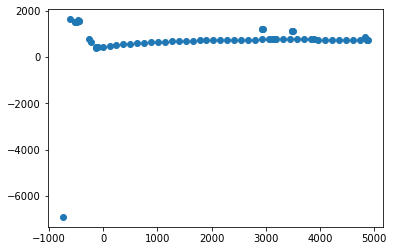

In [247]:
from matplotlib import pyplot as plt
%matplotlib inline
xs = [mv.pt.x for mv in smergeverts]
ys = [mv.pt.y for mv in smergeverts]
plt.scatter(xs, ys)

In [234]:

smv = smergeverts.copy()

class TreeVert:
    def __init__(self, mv, cc, e, bfore, depth, lngth, rejoined):
        self.mv = mv
        self.e = e
        self.b
        self.pt = mv.pt
        self.cc = cc
        self.depth = depth
        self.lngth
        self.rejoined = rejoined
        if not rejoined:
            self.leaves = [ ]

            
mvtreedict = { }
mv0 = min(smv, key=lambda X: X.pt)
cc = 0

tv0 = TreeVert(mv0, cc, 0, 0.0)
smv.erase(tv0)
stack = [ (tv0, -1) ]
mvtreedict[mv0] = tv0
while len(stack) != 0:
    tv, i = stack.pop()
    i += 1
    if i < len(tv.mv.jseq)
        e, bfore, mv1 = tv.mv.jseq[i]
        mvu = mv1.ultimatesuccessor()
        if mvu not in mvtreedict:
            pass
        else:
            tve = mvtreedict[mvu]
            assert tv.cc == cc
            tv.leaves.append(TreeVert(mvu, ))


In [140]:
cutlayers = [ "BSF-CUT-BOTH" ]

class GEdge:
    def __init__(self, e):
        self.vertfore = None
        self.vertback = None
        self.e = e
    def setvertjoin(self, gvertexjoin, bfore):
        if bfore:
            assert self.vertback == None
            self.vertback = gvertexjoin
        else:
            assert self.vertfore == None
            self.vertfore = gvertexjoin

class GEdgedirected:
    def __init__(self, ge, bfore):
        self.ge = ge
        self.bfore = bfore
        self.ptend = front(ge.e) if bfore else back(ge.e)
        self.referenced = False
    

class GVertexJoin:
    def __init__(self, gedgedirected):
        self.gedgesdirectedjoin = [ gedgedirected ]
    def add(self, gedgedirected):
        self.gedgesdirectedjoin.append(gedgedirected)
        
        
gedges = [ ]
gedgesdirected = [ ]
for e in d.entities:
    if e.dxf.layer in cutlayers:
        ge = GEdge(e)
        gedges.append(ge)
        gedgesdirected.append(GEdgedirected(ge, True))
        gedgesdirected.append(GEdgedirected(ge, False))

gedgesdirected.sort(key=lambda X: X.ptend)      

In [141]:
closedist = 0.32
gedgesvertexjoins = [ ]
i = 0
for ged in gedgesdirected:  ged.referenced = False
while i < len(gedgesdirected):
    if not gedgesdirected[i].referenced:
        gedgesvertexjoin = GVertexJoin(gedgesdirected[i])
        gedgesdirected[i].referenced = True
        j = i
        while j + 1 < len(gedgesdirected) and gedgesdirected[j+1].ptend.x - gedgesdirected[i].ptend.x <= closedist:
            j += 1
            if not gedgesdirected[j].referenced and (gedgesdirected[j].ptend - gedgesdirected[i].ptend).magnitude <= closedist:
                gedgesvertexjoin.add(gedgesdirected[j])
                gedgesdirected[j].referenced = True
        gedgesvertexjoins.append(gedgesvertexjoin)
    i += 1
    



In [151]:
for gedge in gedges:  gedge.vertfore, gedge.vertback = None, None
for gvertexjoin in gedgesvertexjoins:
    for gedgedirected in gvertexjoin.gedgesdirectedjoin:
        gedgedirected.ge.setvertjoin(gvertexjoin, gedgedirected.bfore)
for gedge in gedges:
    assert(gedge.vertfore != None and gedge.vertback != None)
    

In [75]:
sum((ezdxf.math.vector.Vector(a)-ezdxf.math.vector.Vector(b)).magnitude  for a, b in zip(e._control_points, e._control_points[1:]))

5334.0823718588435

In [200]:
# this is the source of the doubling up index and then odd/even value to denote either which node (front 
# or back) of the edge, or the direction of the edge.  Recording as this way (rather than [index, bdirection] pairs) 
# means we have a good way to index into parallel table of other things, in the way that pairs cannot look things up, 
# even though this is a little less intuitive and clear. In C++ we would have done this as a struct with accessor functions
def FPSrlidat(rlends, closedist):
    rlidat = [ ]; # index*2 + (front ? 1 : 0[back])
    for i in range(len(rlends)*2):
        rlidat.append([ ]); # each will be a list of cross connections [d, j]  (these are not pairs of 
    
    closedistSq = closedist*closedist; 
    for j in range(len(rlends)):
        rle = rlends[j]; 
        pB = rle[0] 
        jd = rle[1]*2 + (1 if rle[2] else 0);  # encoding the index as *2 + (forward ? 1 : 0)
        
        # loop through forwards (constrained by beyond the x-direction wider than closedist
        j1 = j+1
        while ((j1 < len(rlends)) and (rlends[j1][0].x <= pB.x + closedist)):
            rle1 = rlends[j1]; 
            d = rle1[0] - pB;
            dClen = d.magnitude; 
            dCsq = dClen*dClen
            if ((dClen <= closedist) and ((rle[1] != rle1[1]) or (rle[3] > closedist))): # { /* avoid connecting short line segment back to self (unless long enough to be a loop) */
                jd1 = rle1[1]*2 + (1 if rle1[2] else 0); 
                rlidat[jd].append([dCsq, jd1]); 
                rlidat[jd1].append([dCsq, jd]); 
            j1 += 1

    # sort adjacencies at endpoints by distance
    for i in range(len(rlidat)):
        rlidat[j].sort(); 
    return rlidat; 


In [201]:
def disconnectJD1(rlidat, jd, jd1): # disconnects the other end of any link we are deleting (usually by popping)
    rlid1 = rlidat[jd1]; 
    #console.log("disconjd", jd, jd1, rlid1.slice()); 
    d1i = len(rlid1) - 1
    while d1i >= 0:
        if (rlid1[d1i][1] == jd):
            break; 
        d1i -= 1
    d1i += 1
    while (d1i < len(rlid1)):
        rlid1[d1i-1] = rlid1[d1i]; 
        d1i += 1
    rlid1.pop(); 


In [202]:
def FPSjdseqs(rlidat):
    dlistlen = len(rlidat)//2
    # extract closed sequences of paths that join up
    jdseqs = [ ];  
    i = 0; 

    rlconns = 0; 
    for j in range(len(rlidat) - 1): 
        rlconns += len(rlidat[j]); 
    Dloops = rlconns*2 + dlistlen;  # used to trap infinite loops

    # this will only find forward following loops (jd=i*2+1)
    while (i < dlistlen):
        Dloops -= 1
        assert(Dloops >= 0); # catches infinite loops
        
        # disconnect any endpoint going backwards
        if (len(rlidat[i*2]) == 0):
            # then disconnect forward links from here
            if (len(rlidat[i*2 + 1]) == 0):
                i += 1; 
            else:
                jd = i*2 + 1; 
                while (len(rlidat[jd]) != 0):
                    disconnectJD1(rlidat, jd, rlidat[jd].pop()[1]); 
        # line is an endpoint going forward 
        elif (len(rlidat[i*2 + 1]) == 0):
            jd = i*2; 
            while (len(rlidat[jd]) != 0):
                disconnectJD1(rlidat, jd, rlidat[jd].pop()[1]); 
            
        # not an endpoint going forwards, follow round to see if it forms a loop
        else:
            jdseq = [ ]; 
            jd0 = i*2 + 1; 
            jd = jd0; 
            while (True):
                
                # we've chased through and hit an end, take it out
                if (len(rlidat[jd]) == 0):
                    jdl = jdseq.pop(); 
                    #print("removing jdl", jdl, jd0); 
                    disconnectJD1(rlidat, jdl, rlidat[jdl].pop(0)[1]); 
                    break; 
                    
                # we've exceeded the number of edges possible, so time to quit (and take out the starting point)
                elif ((len(jdseq) > dlistlen - i*0) or ((len(jdseq) != 0) and (jdseq[len(jdseq)-1] == jd))):
                    #print("removing jd0 semiloop", jd0); 
                    disconnectJD1(rlidat, jd0, rlidat[jd0].pop(0)[1]); 
                    break; 
                    
                # this is the part actually continue chasing through the 2-way connections (pretty important but hard)
                else:
                    jdseq.append(jd); 
                    jd1 = rlidat[jd][0][1];  # pick closest out of the list here
                    
                    # (except try to avoid looping back on self if possible)
                    if ((len(jdseq) >= 2) and (jdseq[len(jdseq) - 2] == jd1) and (len(rlidat[jd]) >= 2)):
                        #print("Avoid obvious loop backwards"); 
                        jd1 = rlidat[jd][1][1];  # pick second closest out of the list here

                    jd = jd1 + (-1 if (jd1%2) == 1 else 1); 
                    
                    # we've looped around to starting point
                    if (jd == jd0): 
                        break; 

            # got a closed cycle.  Disconnect everything else around it
            if (jd == jd0):
                #print("found cycle", jdseq); 
                jdseqs.append(jdseq); 
                ijd = 0
                while (ijd < len(jdseq)):
                    jd = jdseq[ijd]; 
                    while (len(rlidat[jd]) != 0):
                        disconnectJD1(rlidat, jd, rlidat[jd].pop()[1]); 
                    
                    jd1 = jd + (-1 if (jd%2) == 1 else 1); 
                    while (len(rlidat[jd1]) != 0):
                        disconnectJD1(rlidat, jd1, rlidat[jd1].pop()[1]); 
                    ijd += 1
                i += 1 
    return jdseqs; 



In [206]:
#FPSrlendsPC: function(pencutseqs, etchseqslen) // etchseqslen is the pencuts at the front that are etch numbers
def FPSrlendsPC(cuts):
    rlends = [ ]; # [ x, y, i, bfore, pathlength ]
    for i, e in enumerate(cuts):
        l = length(e)
        rlends.append([ front(e), i, False, l ]); 
        rlends.append([ back(e), i, True, l ]); 
    rlends.sort(); 
    return rlends; 


cutlayers = [ "BSF-CUT-BOTH" ]
dxfcuts = [ ]
for e in d.entities:
    if e.dxf.layer in cutlayers:
        dxfcuts.append(e)


# FindClosedPathSequencesD: function(dlist, closedist)
#    // create arrays of closest links  (dlist can be padded with nulls to knock out values but retain the indexes)
#    var rlends = this.FPSrlends(dlist, dlist.length); // [ x, y, i, bfore, pathlength ]
#    var rlidat = this.FPSrlidat(rlends, dlist.length, closedist); 
#    return this.FPSjdseqs(rlidat, dlist.length); 
closedist = 0.32
rlends = FPSrlendsPC(dxfcuts)
rlidat = FPSrlidat(rlends, closedist); 
jdseqs = FPSjdseqs(rlidat); 
print(jdseqs)



[]
